<a href="https://colab.research.google.com/github/Vijay06111998/MONAI_Brain_Tumer-_Segmentation/blob/main/Brain_Tumer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Brain tumor 3D segmentation with MONAI

This  shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.


## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

2025-04-13 03:02:25.435888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744513345.690022    2643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744513345.756282    2643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 03:02:26.279800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup imports

In [ ]:
import os
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
import shutil
import tempfile
import time
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()

MONAI version: 1.5.dev2514
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a3ea49fc4e600d131daadad61ea340df25fcfdaa
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

## Setup data directory

We try to download the dataset in gogole drive.

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')

import os
# Save data to Google Drive
os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/MONAI_Data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")

if directory is not None:
    os.makedirs(directory, exist_ok=True)
    root_dir = directory
else:
    import tempfile
    root_dir = tempfile.mkdtemp()

print("📂 Dataset will be stored in:", root_dir)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Dataset will be stored in: /content/drive/MyDrive/MONAI_Data


In [ ]:
'''import os

# Path to the shared dataset
os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/MONAI_Data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = os.path.join(directory)

print("📂 Dataset loaded from:", root_dir)
'''

📂 Dataset loaded from: /content/drive/MyDrive/MONAI_Data


## Set deterministic training for reproducibility

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
set_determinism(seed=0)

# Checking Tensor

In [ ]:
''' from monai.apps import DecathlonDataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd

raw_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
])

raw_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=raw_transform,
    section="training",
    download=True,
    cache_rate=0.0,
)

sample = raw_ds[0]
'''

Task01_BrainTumour.tar: 7.09GB [06:06, 20.8MB/s]                            


2025-04-12 02:28:43,386 - INFO - Downloaded: /content/drive/MyDrive/MONAI_Data/Task01_BrainTumour.tar
2025-04-12 02:29:34,399 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-04-12 02:29:34,401 - INFO - Writing into directory: /content/drive/MyDrive/MONAI_Data.


In [ ]:
'''
print("Image Tensor Shape:", sample["image"].shape)
print("Label Tensor Shape:", sample["label"].shape)
'''

Image Tensor Shape: torch.Size([4, 240, 240, 155])
Label Tensor Shape: torch.Size([1, 240, 240, 155])


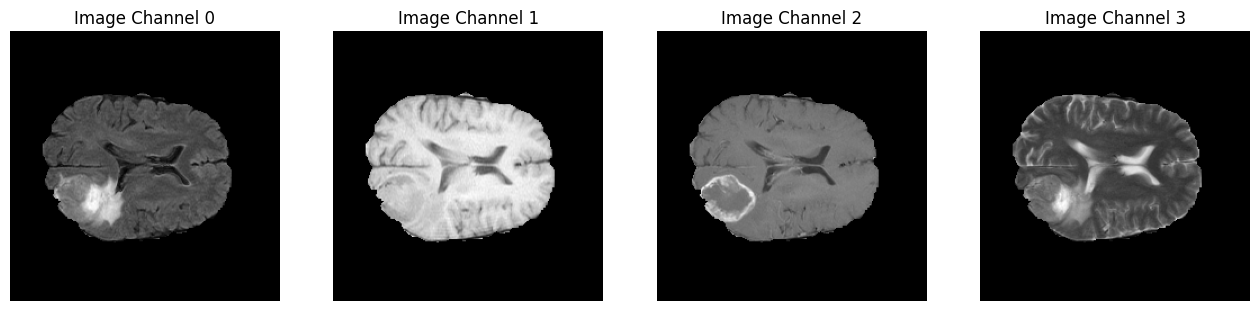

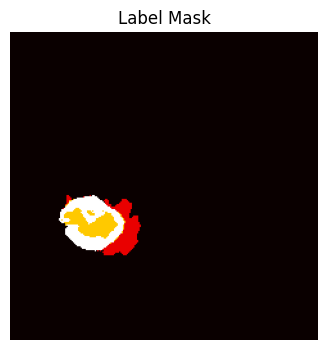

In [ ]:
'''
import matplotlib.pyplot as plt

image_tensor = sample["image"]
label_tensor = sample["label"]
slice_index = 77  # middle slice in depth (Z-axis)

# Plot all 4 MRI modalities
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(image_tensor[i, :, :, slice_index].detach().cpu(), cmap="gray")
    plt.title(f"Image Channel {i}")
    plt.axis("off")
plt.show()

# Plot the label (tumor segmentation mask)
plt.figure(figsize=(4, 4))
plt.imshow(label_tensor[0, :, :, slice_index].detach().cpu(), cmap="hot")
plt.title("Label Mask")
plt.axis("off")
plt.show()
'''

| Color       | Label ID | Meaning                         | Medical Name                        |
|-------------|----------|----------------------------------|-------------------------------------|
| 🟥 **Red**   | 1        | Edema                           | Swelling around tumor               |
| 🟡 **Yellow**| 2        | Enhancing tumor                 | Actively growing part with blood    |
| ⚪ **White** | 3        | Necrotic / Non-enhancing core   | Dead or inactive tumor tissue       |


**T1-weighted MRI - Image class 0**

What is it?

- T1-weighted MRI provides excellent anatomical details.
- Fat and normal brain structures appear brighter.
- Fluid (like cerebrospinal fluid or edema) appears darker.

Why use it?

- Great for viewing general anatomy, normal tissues, and structure of the brain.
- Helps in clearly defining the boundaries of anatomical regions.

Appearance:

- Gray matter(neuron cell bodies, dendrites, and synapses.Located on the  outer surface of the brain): Dark gray

- White matter( myelinated axons (nerve fibers). Myelin is a fatty, insulating layer that speeds up nerve signals.): Brighter gray

- CSF (cerebrospinal fluid): Dark (almost black)
- Fat and bone marrow: Bright white

**T1 with Gadolinium (T1Gd)**

- Gadolinium (Gd) is a contrast agent (a special dye injected into the bloodstream before an MRI scan).

- Normally, this contrast does not cross the "blood-brain barrier" (a protective barrier that keeps harmful substances from entering the brain).

- However, tumors, inflammation, or damaged tissue disrupt this barrier, allowing gadolinium to leak into these areas.

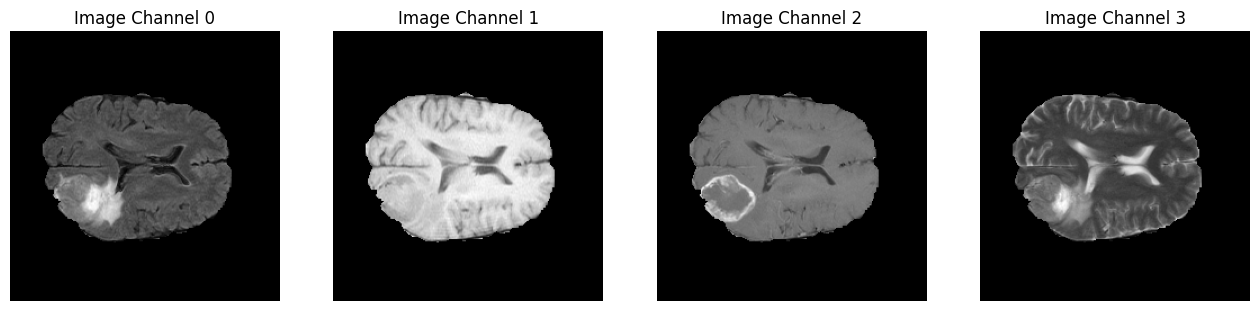

**T1Gd clearly highlights:**

- Tumors (especially active, growing tumors).
- Inflammation areas.
- Infections or blood vessel problems.

- Fat: Still bright white
- White matter: Still brighter gray
- Gray matter: Still darker gray
- Tumors/abnormal tissue: Clearly bright white due to gadolinium leakage, significantly easier to detect.

**T2 - Assessing tumor impact and related swelling - Fluid, edema, cysts, inflammation**

**Tissue	Brightness on T2**


- Fluid (CSF, edema)	Bright white
- White matter	Dark gray
- Gray matter	Light gray
- Fat	Moderate
- Tumor	Variable (but if there's fluid/swelling, part of it may appear bright)

💧 Fluid (CSF)

- You’ll notice very bright regions in the shape of a butterfly in the center of the brain — this is cerebrospinal fluid (CSF) in the ventricles.

- CSF always appears very bright on T2 — that’s normal.



**You’ll see an irregular bright white patch around a darker center.**

* This bright surrounding region is peritumoral edema — swelling caused by the tumor pressing or leaking into surrounding brain tissue.

* It looks hazy and spreads outward — that’s fluid trapped in the tissue (like inflammation), and T2 makes it glow.

**Why do we use FLAIR**

- In regular T2 images, both edema (abnormal fluid) and CSF (normal fluid) are bright — which can make it hard to spot tumors or lesions near the ventricles (fluid-filled spaces).

**FLAIR removes the brightness of CSF, so:**

- Lesions or edema remain bright ✅

- CSF becomes dark ❌

- This makes abnormal fluid stand out more clearly.

✅ **Channel 3 (T2-weighted MRI)**


**Strengths:**
- Shows ALL fluids as bright white:
- Edema
- CSF (cerebrospinal fluid)
- Excellent for detecting swelling, cysts, and fluid-filled abnormalities.

**Limitation:**
- Sometimes it's hard to separate edema from CSF, especially when the tumor is near the ventricles (which also appear bright).

**✅ Channel 0 (FLAIR)**

**Strengths:**

- Suppresses CSF, so it's dark.
- Keeps edema and lesions bright → Makes them stand out more clearly!
- Best for visualizing tumors near CSF, like next to ventricles or subarachnoid spaces.

**Limitation:**
Sometimes a bit noisier than T2 in general contrast.

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [ ]:
#Check Drive space
import shutil
total, used, free = shutil.disk_usage(root_dir)
print(f"🧮 Total: {total // (2**30)} GB, Free: {free // (2**30)} GB")
if free < 2 * 1024**3:
    print("❌ Drive might be full. Consider cleaning up space.")

🧮 Total: 15 GB, Free: 0 GB
❌ Drive might be full. Consider cleaning up space.


In [ ]:
'''from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import LoadImaged, Compose
from monai.transforms.transform import MapTransform

# 🛠️ Debug print utility
class PrintShape(MapTransform):
    def __init__(self, keys, message):
        super().__init__(keys)
        self.message = message

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                print(f"{self.message} | {key} shape: {d[key].shape}, type: {type(d[key])}")
        return d

# ----------------------------------------
# STEP 1: Raw dataset loader (no transforms except LoadImaged)
# ----------------------------------------
raw_loader = Compose([LoadImaged(keys=["image", "label"])])

raw_train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
    transform=raw_loader
)
raw_train_loader = DataLoader(raw_train_ds, batch_size=1, shuffle=True, num_workers=2)

raw_val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    download=True,
    cache_rate=0.0,
    num_workers=4,
    transform=raw_loader
)
raw_val_loader = DataLoader(raw_val_ds, batch_size=1, shuffle=False, num_workers=2)

# ----------------------------------------
# STEP 2: Manual transform - Training
# ----------------------------------------
from monai.transforms import (
    EnsureChannelFirstd, EnsureTyped, ConvertToMultiChannelBasedOnBratsClassesd,
    Orientationd, Spacingd, RandSpatialCropd, RandFlipd,
    NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd
)

manual_train_transform = Compose([
    PrintShape(keys=["image", "label"], message="After LoadImaged"),

    EnsureChannelFirstd(keys="image"),
    PrintShape(keys=["image"], message="After EnsureChannelFirstd"),

    EnsureTyped(keys=["image", "label"]),
    PrintShape(keys=["image", "label"], message="After EnsureTyped"),

    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    PrintShape(keys=["label"], message="After ConvertToMultiChannelBasedOnBratsClassesd"),

    Orientationd(keys=["image", "label"], axcodes="RAS"),
    PrintShape(keys=["image", "label"], message="After Orientationd"),

    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    PrintShape(keys=["image", "label"], message="After Spacingd"),

    RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
    PrintShape(keys=["image", "label"], message="After RandSpatialCropd"),

    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    PrintShape(keys=["image", "label"], message="After RandFlipd"),

    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    PrintShape(keys=["image"], message="After NormalizeIntensityd"),

    RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    PrintShape(keys=["image"], message="After RandShiftIntensityd"),
])

# ----------------------------------------
# STEP 3: Manual transform - Validation
# ----------------------------------------
manual_val_transform = Compose([
    PrintShape(keys=["image", "label"], message="After LoadImaged"),

    EnsureChannelFirstd(keys="image"),
    PrintShape(keys=["image"], message="After EnsureChannelFirstd"),

    EnsureTyped(keys=["image", "label"]),
    PrintShape(keys=["image", "label"], message="After EnsureTyped"),

    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    PrintShape(keys=["label"], message="After ConvertToMultiChannelBasedOnBratsClassesd"),

    Orientationd(keys=["image", "label"], axcodes="RAS"),
    PrintShape(keys=["image", "label"], message="After Orientationd"),

    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    PrintShape(keys=["image", "label"], message="After Spacingd"),

    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    PrintShape(keys=["image"], message="After NormalizeIntensityd"),
])

# ----------------------------------------
# STEP 4: Apply transforms manually
# ----------------------------------------

# 🧪 Training sample (manual)
for i, raw in enumerate(raw_train_loader):
    print(f"\n🔍 Train Sample {i}")
    sample = {
        "image": raw["image"][0],  # remove batch dimension
        "label": raw["label"][0]
    }
    sample = manual_train_transform(sample)


# 🧪 Validation sample (manual)
for i, raw in enumerate(raw_val_loader):
    print(f"\n🔍 Val Sample {i}")
    sample = {
        "image": raw["image"][0],  # remove batch dimension
        "label": raw["label"][0]
    }
    sample = manual_val_transform(sample)

'''

Streaming output truncated to the last 5000 lines.
After Spacingd | image shape: torch.Size([4, 240, 240, 155]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After Spacingd | label shape: torch.Size([3, 240, 240, 155]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After RandSpatialCropd | image shape: torch.Size([4, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After RandSpatialCropd | label shape: torch.Size([3, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After RandFlipd | image shape: torch.Size([4, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After RandFlipd | label shape: torch.Size([3, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After NormalizeIntensityd | image shape: torch.Size([4, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>
After RandShiftIntensityd | image shape: torch.Size([4, 224, 224, 144]), type: <class 'monai.data.meta_tensor.MetaTensor'>

🔍 Train Samp

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation", # can give test as well
    download=True,
    cache_rate=0.0,
    num_workers=8,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**BrainTumour**


├── imagesTr/     ← 🧠 Training Images (T1, T1Gd, T2, FLAIR) for each subject


├── labelsTr/     ← 🩺 Training Labels (segmentation masks)


├── imagesTs/     ← 🔍 Testing Images (used for inference only — no labels provided)


├── dataset.json  ← 📄 Metadata config used by MONAI


## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

We are going to **transform** the training data rightaway when we load it. We perform the following operations

1. **LoadImaged(keys=["image", "label"]):** Load Images .nii.gz with LoadImaged
2. **EnsureChannelFirstd:** Converts HWDC to CHWD (Pytorch format requirement ie batch, channel, height, width, depth)
3. **EnsureTyped:** Converts the number numpy matrix to float as pytorch needs it.
4. **Convert to multi channel based on brats classed:** Converting the single channel labels into three binary output (Red, yellow, white)

Color	Label ID	Meaning	Medical Name
🟥 Red	1	Edema	Swelling around tumor
🟡 Yellow	2	Enhancing tumor	Actively growing part with blood
⚪ White	3	Necrotic / Non-enhancing core	Dead or inactive tumor tissue

5. **Orientationd:** Rotates the brain into Right antirior superior direction. Different hospitals could take the MRI scan in different directions. so we try to ensure that we see everything from same angle.

6. ** Spacingd: ** give spacing to the voxels. Resamples the 3D scan to have uniform voxel resolution

Different hospitals or MRI machines use different **voxel resolutions** (spacing), which can change how tumors appear in scans.

| Hospital | Voxel Size (mm)       | Meaning                     |
|----------|------------------------|-----------------------------|
| A        | [1.0, 1.0, 1.5]        | Thick slices, fewer details |
| B        | [0.78, 0.78, 1.0]      | High resolution scan        |
| C        | [1.25, 1.25, 1.25]     | Uniform but low detail      |

⚠️ This variation causes the **same tumor** to appear **larger, smaller, or distorted**, which confuses your model if not corrected.

7. **RandSpatialCropd(roi_size=[224, 224, 144]):** Doing it to avoid overfitting. We do RANDOM Crop without a tumer aware.

  - If tumor is missed → it's still okay (model learns background).
  - If tumor is hit → it learns to segment it.

8. **Random Flipping:**

| Problem                         | What It Looks Like                                  | Why It's Bad                                      |
|----------------------------------|------------------------------------------------------|---------------------------------------------------|
| ❌ Model memorizes position      | Thinks "tumor is always in the left side of brain"   | It fails when tumor appears on right              |
| ❌ Learns direction-specific features | Only learns left-to-right shapes                  | Won’t recognize flipped versions                  |
| ❌ Less variation in training    | Sees the same brain region over and over            | Poor generalization to real-world scans           |


| Benefit                                       | Description                                                                                                   |
|-----------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| 🔁 1. Directional Invariance                   | Tumors can occur on the left, right, or in random spots. Flipping teaches the model to focus on tumor **shape**, not **location**. |
| 🎨 2. Increased Dataset Variety Without Extra Data | One scan can be flipped in X, Y, Z → up to 8 variations. 100 scans become 800 examples. Massive data boost ✅ |
| 🧠 3. Better Shape Recognition                 | Tumors grow in different directions. Flipping teaches the model to understand mirrored patterns and symmetry. |
| 💻 4. Works Like Human Brain Training          | Doctors are trained on scans from many angles. Flipping gives the model that same robust learning experience.  |

9. **NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True):**

| Reason                          | Explanation                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| 🧲 Different MRI machines        | Different vendors (GE, Siemens, Philips) use different signal ranges        |
| ⚙️ Different acquisition settings| Parameters like echo time, repetition time affect brightness                |
| 🎛️ Different coil calibrations   | Machine-specific tuning of signal sensitivity                               |
| 🧬 Patient-specific tissue response | Everyone’s body responds slightly differently to the magnetic field     |
| 💉 Contrast agent usage (T1Gd)   | Some scans use Gadolinium (contrast dye), some don’t                        |

we normalize the data to have mean of 0 and std of 1.


| Transform             | What It Simulates           | How It Helps                                      |
|------------------------|------------------------------|---------------------------------------------------|
|10.  `RandScaleIntensityd` | MRI scan contrast changes    | Helps model learn structure, not brightness       |
|11.  `RandShiftIntensityd` | MRI brightness drift         | Helps model adapt to scanner differences          |



In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## Check data shape and visualize - validation_df (displaying validation set images)

image shape: torch.Size([4, 240, 240, 155])


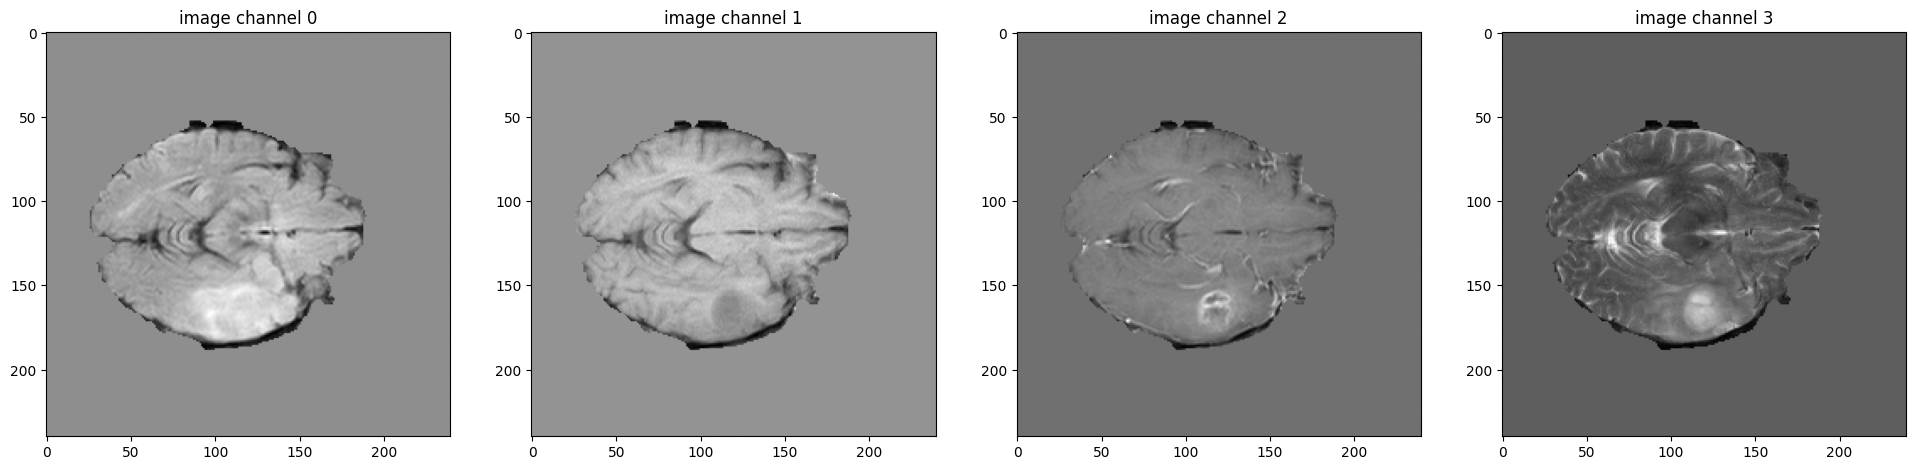

label shape: torch.Size([3, 240, 240, 155])


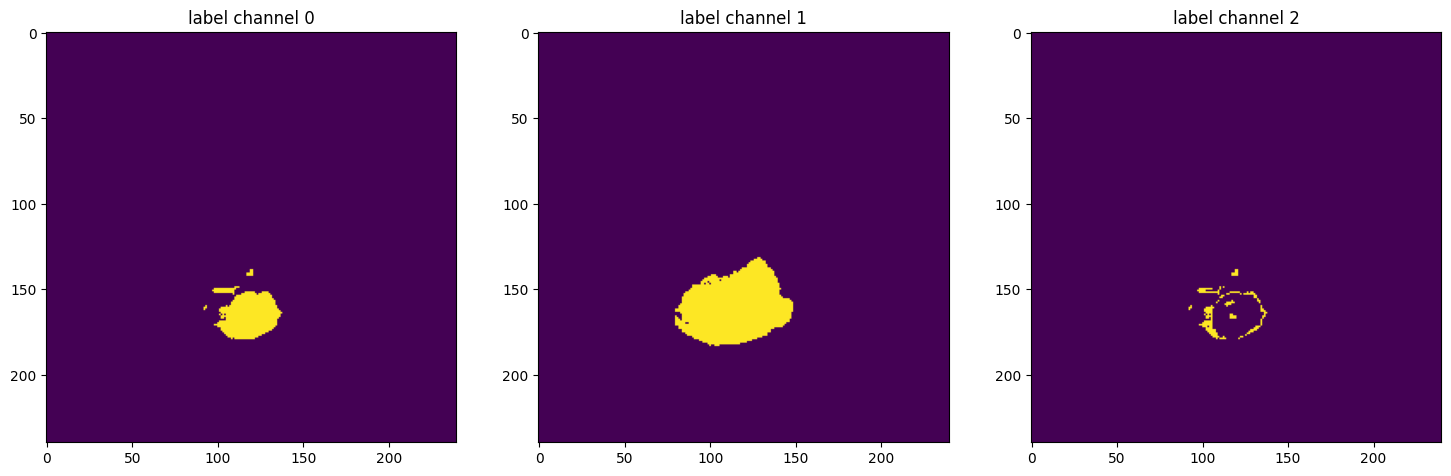

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

# Lets check shape after data transformation

## Create Model, Loss, Optimizer

In [ ]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")


model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)


loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.autocast("cuda"):
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.GradScaler("cuda")
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.autocast("cuda"):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/388, train_loss: 0.9783, step time: 14.5992
2/388, train_loss: 0.9804, step time: 1.0012
3/388, train_loss: 0.9883, step time: 1.0148
4/388, train_loss: 0.9560, step time: 1.1999
5/388, train_loss: 0.9834, step time: 1.3127
6/388, train_loss: 0.9384, step time: 1.1733
7/388, train_loss: 0.9720, step time: 1.2431
8/388, train_loss: 0.9390, step time: 1.2762
9/388, train_loss: 0.9850, step time: 1.1416
10/388, train_loss: 0.9416, step time: 1.0797
11/388, train_loss: 0.8950, step time: 1.0401
12/388, train_loss: 0.8882, step time: 1.1704
13/388, train_loss: 0.9638, step time: 1.1749
14/388, train_loss: 0.8995, step time: 1.2033
15/388, train_loss: 0.9295, step time: 1.1462
16/388, train_loss: 0.9564, step time: 1.1780
17/388, train_loss: 0.9711, step time: 1.2355
18/388, train_loss: 0.9355, step time: 1.0614
19/388, train_loss: 0.9584, step time: 1.2038
20/388, train_loss: 0.8865, step time: 1.0742
21/388, train_loss: 0.9407, step time: 1.2798
22/388, train_loss:

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best pytorch model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

## Convert torch to onnx model

In [ ]:
dummy_input = torch.randn(1, 4, 240, 240, 160).to(device)
onnx_path = os.path.join(root_dir, "best_metric_model.onnx")
torch.onnx.export(model, dummy_input, onnx_path, verbose=False)

## Inference onnx model
Here we change the model used by predictor to onnx_infer, both of which are used to obtain a tensor after the input has been reasoned by the neural network.

Note: If the warning `pthread_setaffinity_np failed` appears when executing this cell, this is a known problem with the onnxruntime and does not affect the execution result. If you want to disable the warning, you can cancel the following comment to solve the problem.

In [ ]:
# Using the following program snippet will not affect the execution time.
# options = ort.SessionOptions()
# options.intra_op_num_threads = 1
# options.inter_op_num_threads = 1

In [ ]:
def onnx_infer(inputs):
    ort_inputs = {ort_session.get_inputs()[0].name: inputs.cpu().numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    return torch.Tensor(ort_outs[0]).to(inputs.device)


def predict(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=4,
            predictor=onnx_infer,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.autocast("cuda"):
            return _compute(input)
    else:
        return _compute(input)

In [ ]:
onnx_model_path = os.path.join(root_dir, "best_metric_model.onnx")
ort_session = onnxruntime.InferenceSession(onnx_model_path)

for val_data in tqdm(val_loader, desc="Onnxruntime Inference Progress"):
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )

    ort_outs = predict(val_inputs)
    val_outputs = post_trans(torch.Tensor(ort_outs[0]).to(device)).unsqueeze(0)

    dice_metric(y_pred=val_outputs, y=val_labels)
    dice_metric_batch(y_pred=val_outputs, y=val_labels)
onnx_metric = dice_metric.aggregate().item()
onnx_metric_batch = dice_metric_batch.aggregate()
onnx_metric_tc = onnx_metric_batch[0].item()
onnx_metric_wt = onnx_metric_batch[1].item()
onnx_metric_et = onnx_metric_batch[2].item()

print(f"onnx metric: {onnx_metric}")
print(f"onnx_metric_tc: {onnx_metric_tc:.4f}")
print(f"onnx_metric_wt: {onnx_metric_wt:.4f}")
print(f"onnx_metric_et: {onnx_metric_et:.4f}")

## Check best onnx model output with the input image and label

In [ ]:
onnx_model_path = os.path.join(root_dir, "best_metric_model.onnx")
ort_session = onnxruntime.InferenceSession(onnx_model_path)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    ort_output = predict(val_input)
    ort_output = post_trans(torch.Tensor(ort_output[0]).to(device)).unsqueeze(0)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"pth output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"onnx output channel {i}")
        plt.imshow(ort_output[0, i, :, :, 70].detach().cpu())
    plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)